In [1]:
from lineage.AffMB import *
import pandas as pd
import os
import scanpy as sc
import anndata
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import torch
from collections import Counter
import scipy.stats as stats
from scipy.signal import argrelextrema
import matplotlib as mpl
import brewer2mpl
from statannotations.Annotator import Annotator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import mannwhitneyu

Matplotlib is building the font cache; this may take a moment.


In [1]:
import umap
umap_model = umap.UMAP(n_components=2, random_state=42)

## All lineage

In [3]:
bcremb = pd.read_csv("/mnt/d/unifiedBCR/benchmark/Embeddings/vaccination_GSE244297/mean_inner01new.pth/embedding.csv").values
gexemb = pd.read_csv("/mnt/d/unifiedBCR/benchmark/Embeddings/vaccination_GSE244297/mean_inner01new.pth/gexembedding.csv").values
datapath = "/mnt/d/BCRdataset/vaccination_GSE244297/integrated"
metadata = pd.read_csv("annotation.csv", index_col="barcode")
bcrfile_path = os.path.join(datapath, "processed_bcr.csv")
bcrfile = pd.read_csv(bcrfile_path, index_col="barcode")
bcrfile['whole_seq'] = bcrfile['fwr1'].str.cat([bcrfile["cdr1"], bcrfile["cdr2"], bcrfile["fwr2"], bcrfile["cdr2"], bcrfile["fwr3"],
                                               bcrfile["cdr3"], bcrfile["fwr4"]])
embeddings = np.concatenate([bcremb, gexemb], axis=1)
embeddings = torch.from_numpy(embeddings)
embeddings = F.normalize(embeddings, dim = -1).numpy()
new_adata = anndata.AnnData(embeddings)
new_adata.obs = metadata
binding = pd.read_csv("integrated/spike_original.csv", index_col="barcode")
new_adata.obs.binding2 = new_adata.obs.binding2.map(binding.label)
new_adata.obs['cdr3'] = pd.read_csv("integrated/processed_bcr.csv").cdr3.tolist()
sc.pp.neighbors(new_adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(new_adata) 

binding = pd.read_csv("integrated/spike_original.csv", index_col="barcode")
new_adata.obs['binding2'] = binding['label']
new_adata.obs['binding2'] = new_adata.obs['binding2'].replace({'spikenegative': 'S-', 'spikepositive': 'S+'})

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [ ]:
affmball = pd.read_csv("affmbouts/all/inherent/all_DAG_filtered2_explained.csv", index_col="barcode")
affmball = affmball[affmball.locus == "IGH"]
#affmball = affmball[affmball['sequence_id'].isin(bcrfile.contig_id.values)]
affmball[affmball.lineage_name == 'IGHV3-48&IGKV3-20H24K21H24K9H45K27']

In [ ]:
# annotation
anno = pd.read_csv("/mnt/d/BCRdataset/vaccination_GSE244297/annotation.csv", index_col="barcode")

affmball = pd.read_csv("affmbouts/all/inherent/all_DAG_filtered2_explained.csv", index_col="barcode")
affmball = affmball[affmball.locus == "IGH"]
#affmball = affmball[affmball['sequence_id'].isin(bcrfile.contig_id.values)]
affmball['binding2'] = new_adata.obs.loc[affmball.index.tolist(), 'binding2']
affmball['timepoint'] = anno.loc[affmball.index.tolist(), 'timepoint']
affmball['population'] = anno.loc[affmball.index.tolist(), 'population']
affmball['isotype'] = anno.loc[affmball.index.tolist(), 'isotype']

In [6]:
filteredout = []
for lineagename in affmball.lineage_name.unique():
    check = affmball[affmball.lineage_name == lineagename]
    if (check.shape[0] > 1) & (check.node_size.values[0] == 1):
        if len(check.sequence_id.unique()) == 1:
            filteredout.append(lineagename)
affmball = affmball[~affmball.lineage_name.isin(filteredout)]

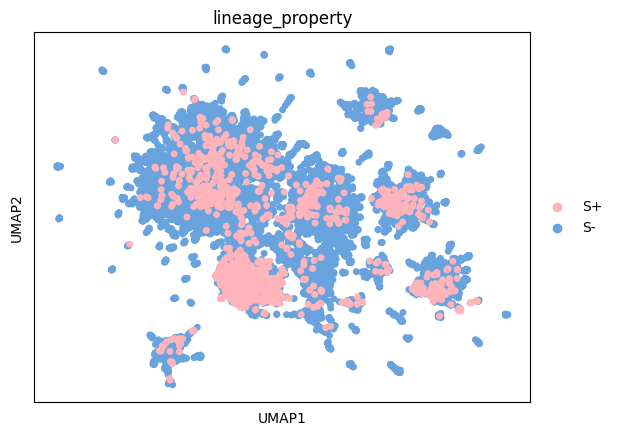

In [7]:
selected_lineages = []
commonS = []
for lineage in affmball.lineage_name.unique():
    subset = affmball[affmball.lineage_name == lineage]
    selected_lineages.append(lineage)
    commonS.extend([Counter(subset.binding2.values).most_common(1)[0][0]]*len(subset))

subadata = new_adata[affmball[affmball.lineage_name.isin(selected_lineages)].index.tolist()]
subadata.obs['lineage_property'] = commonS

# Get boolean masks for S- and S+ observations
s_minus_mask = subadata.obs['lineage_property'] == 'S-'
s_plus_mask = subadata.obs['lineage_property'] == 'S+'

# Get integer positions instead of index names
s_minus_positions = np.where(s_minus_mask)[0]
s_plus_positions = np.where(s_plus_mask)[0]

# Concatenate positions: S- first, then S+
reorder_positions = np.concatenate([s_minus_positions, s_plus_positions])

# Reorder the subadata using integer positions
subadata = subadata[reorder_positions, :]

sc.pp.neighbors(subadata)
sc.tl.umap(subadata)
sc.pl.umap(subadata, color='lineage_property', size=100, 
           palette={"S+": "#ffb3ba", "S-": "#69A3DD"}, show=False)
plt.savefig("/mnt/d/unifiedBCR/figures/lineage/concat/lineage_S+&S-.pdf", bbox_inches='tight', dpi=100)


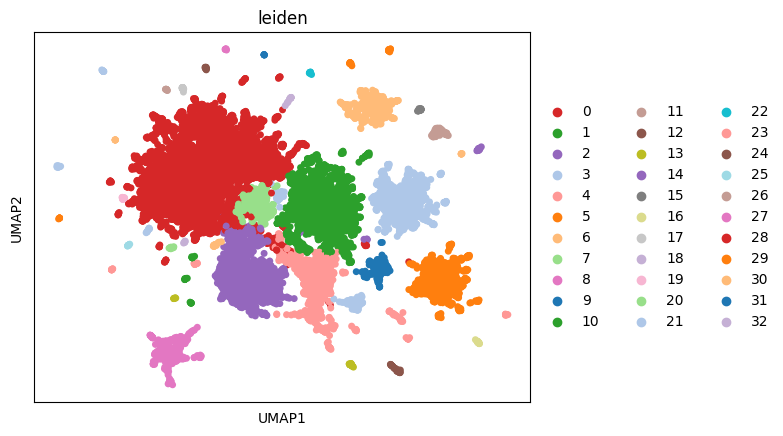

In [8]:
sc.tl.leiden(subadata, resolution=0.1)
clusters = subadata.obs['leiden'].unique()
palette = sns.color_palette("tab20", len(clusters))
cluster_colors = {str(cluster): color for cluster, color in zip(clusters, palette)}
sc.pl.umap(subadata, color=["leiden"], size=100, palette=cluster_colors, show=False)
plt.savefig("/mnt/d/unifiedBCR/figures/lineage/concat/lineage_S+&S-_leiden.pdf", bbox_inches='tight', dpi=100)

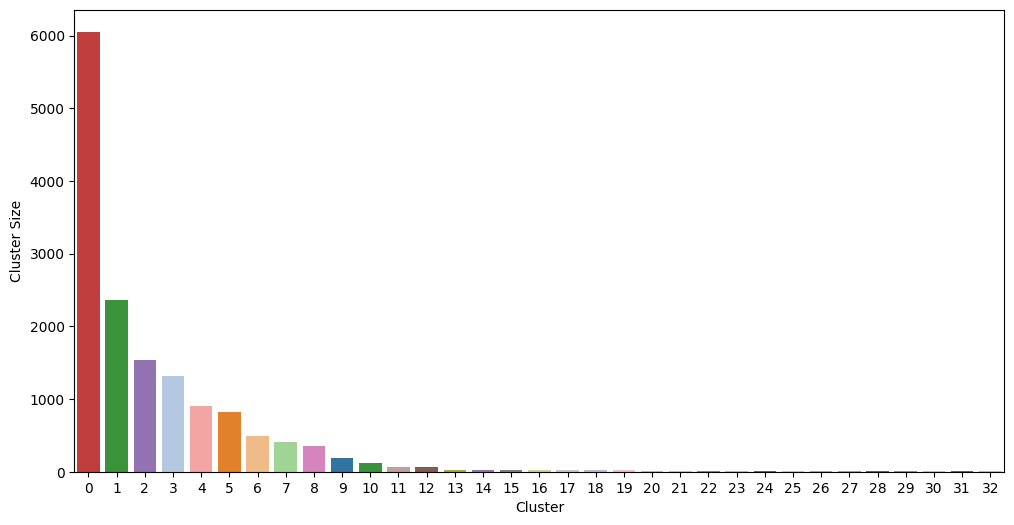

In [9]:
# Create a DataFrame from AnnData's obsd
df = subadata.obs[['leiden', 'binding2']]
# Calculate the ratio of "S+" in each cluster
ratio_s_plus = (df.groupby('leiden')['binding2'].apply(lambda x: (x == 'S+').sum() / x.count()).reset_index(name='Ratio of S+'))

# Calculate the size of each cluster
cluster_sizes = df['leiden'].value_counts().reset_index()
cluster_sizes.columns = ['leiden', 'Cluster Size']

# Merge the ratio and size data for plotting
plot_data = pd.merge(ratio_s_plus, cluster_sizes, on='leiden')
plot_data['Cluster Size'] = plot_data['Cluster Size'] 
# Plot the barplot for the ratio of S+
fig, ax = plt.subplots(figsize=(12, 6))
# Plot the barplot
sns.barplot(data=plot_data, x='leiden', y='Cluster Size', palette=cluster_colors, ax=ax)
ax.set_xlabel('Cluster')
ax.set_ylabel('Cluster Size')
plt.savefig("/mnt/d/unifiedBCR/figures/lineage/concat/lineage_S+&S-_leiden_size.pdf", bbox_inches='tight', dpi=100)

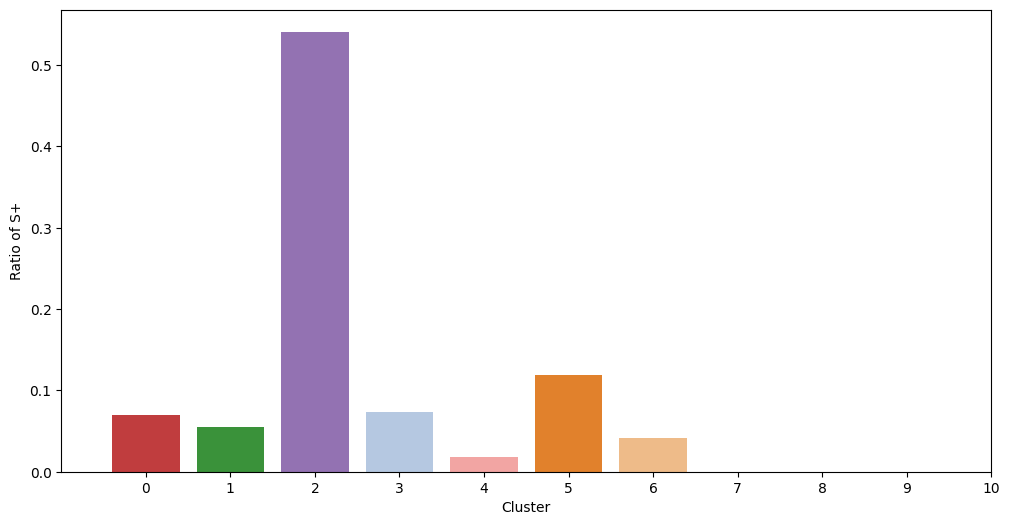

In [11]:
# Create a DataFrame from AnnData's obsd
df = subadata.obs[['leiden', 'binding2']]
# Calculate the ratio of "S+" in each cluster
ratio_s_plus = (df.groupby('leiden')['binding2'].apply(lambda x: (x == 'S+').sum() / x.count()).reset_index(name='Ratio of S+'))

# Calculate the size of each cluster
cluster_sizes = df['leiden'].value_counts().reset_index()
cluster_sizes.columns = ['leiden', 'Cluster Size']

# Merge the ratio and size data for plotting
plot_data = pd.merge(ratio_s_plus, cluster_sizes, on='leiden')

# Plot the barplot for the ratio of S+
fig, ax = plt.subplots(figsize=(12, 6))
# Plot the barplot
sns.barplot(data=ratio_s_plus[ratio_s_plus.leiden.isin(['0','1','2','3','4','5','6'])], x='leiden', y='Ratio of S+', 
            palette=[cluster_colors[str(i)] for i in np.arange(7)], ax=ax)
ax.set_xlabel('Cluster')
ax.set_xlim([-1,10])
ax.set_ylabel('Ratio of S+')
plt.savefig("/mnt/d/unifiedBCR/figures/lineage/concat/lineage_S+&S-_leiden_ratio.pdf", bbox_inches='tight', dpi=100)

Text(0.5, 1.0, 'Histogram of the sizes')

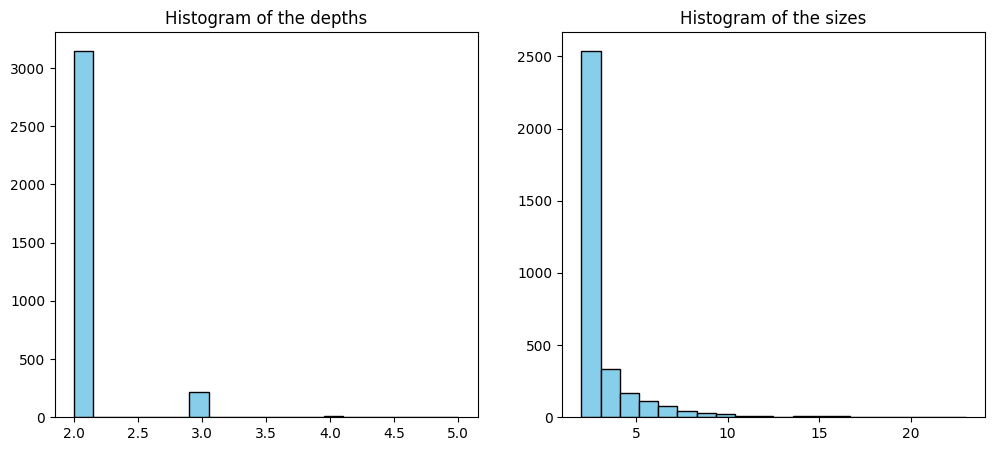

In [14]:
# Assuming count_lineagesize and count_depths are already populated
count_lineagesize = []  # Your calculated lineage sizes
count_depths = []       # Your calculated depths

# Populate count_depths and count_lineagesize as per your loop
for lineage in affmball.lineage_name.unique():
    subset = affmball[affmball.lineage_name == lineage]
    count_depths.append(subset.node_depth.max()+1)
    count_lineagesize.append(subset.lineage_size.values[0])

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot histogram for count_depths
axes[0].hist(count_depths, bins=20, color='skyblue', edgecolor='black')
axes[0].set_title("Histogram of the depths")
# Plot histogram for count_depths
axes[1].hist(count_lineagesize, bins=20, color='skyblue', edgecolor='black')
axes[1].set_title("Histogram of the sizes")

Text(0.5, 1.0, 'Histogram of the sizes with Gaussian fit')

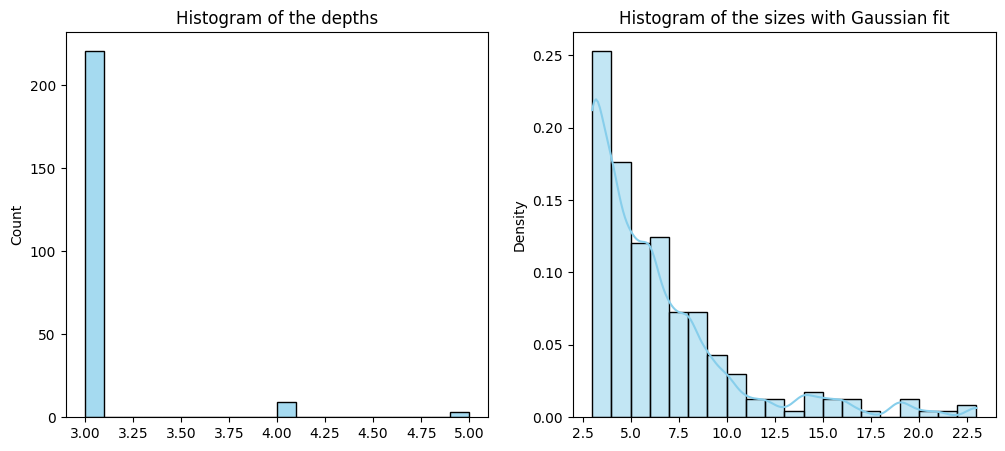

In [15]:
# Assuming count_lineagesize and count_depths are already populated
count_lineagesize = []  # Your calculated lineage sizes
count_depths = []       # Your calculated depths

# Populate count_depths and count_lineagesize as per your loop
for lineage in affmball.lineage_name.unique():
    subset = affmball[affmball.lineage_name == lineage]
    if subset.node_depth.max() >= 2:
        count_depths.append(subset.node_depth.max() + 1)
        count_lineagesize.append(subset.lineage_size.values[0])

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot histogram for count_depths
sns.histplot(count_depths, bins=20, color='skyblue', edgecolor='black', ax=axes[0])
axes[0].set_title("Histogram of the depths")

# Plot histogram for count_lineagesize
sns.histplot(count_lineagesize, bins=20, color='skyblue', edgecolor='black', ax=axes[1], stat='density',
             kde=True, kde_kws={"bw_adjust":0.4})
axes[1].set_title("Histogram of the sizes with Gaussian fit")

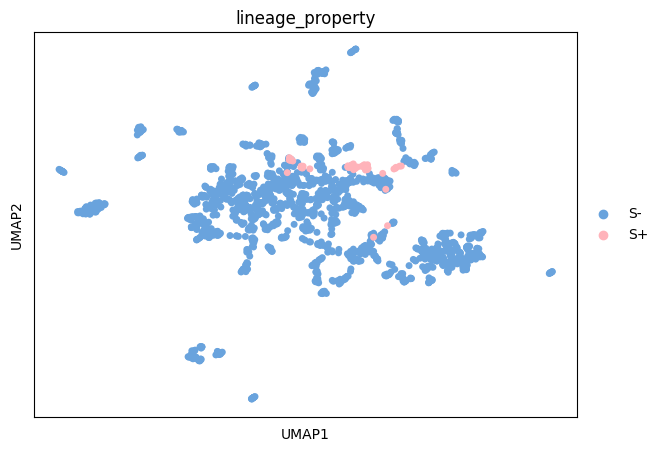

In [12]:
selected_lineages = []
commonS = []
for lineage in affmball.lineage_name.unique():
    subset = affmball[affmball.lineage_name == lineage]
    if (subset.node_depth.max()<2) | (subset.lineage_size.values[0]<5): continue
    selected_lineages.append(lineage)
    commonS.extend([Counter(subset.binding2.values).most_common(1)[0][0]]*len(subset))
subadata = new_adata[affmball[affmball.lineage_name.isin(selected_lineages)].index.tolist()]
subadata.obs['lineage_property'] = commonS

custom_palette = {"S+": "#ffb3ba", "S-": "#69A3DD"}
sc.pp.neighbors(subadata)
sc.tl.umap(subadata)
# Separate the data into S+ and S- subsets
s_plus_data = subadata[subadata.obs['lineage_property'] == 'S+']
s_minus_data = subadata[subadata.obs['lineage_property'] == 'S-']
fig, axes = plt.subplots(figsize=(7,5))
# Plot S- points first
sc.pl.umap(s_minus_data, color='lineage_property', size=100, palette=custom_palette, show=False, ax=axes)
# Overlay S+ points
sc.pl.umap(s_plus_data, color='lineage_property', size=100, palette=custom_palette, show=False, ax=axes)
plt.savefig("/mnt/d/unifiedBCR/figures/lineage/concat/lineage_filtered.pdf", bbox_inches='tight', dpi=100)

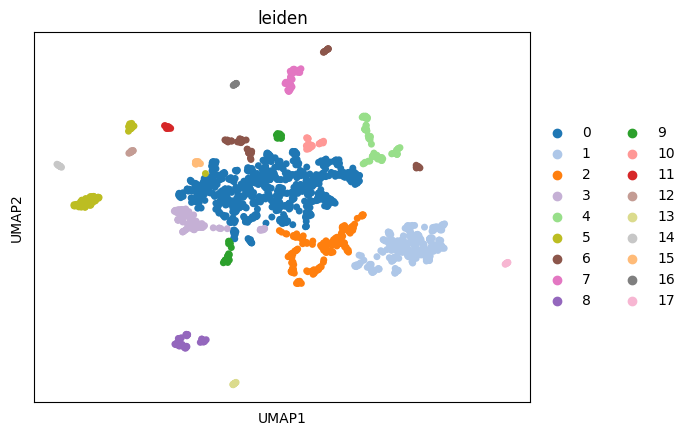

In [11]:
sc.tl.leiden(subadata, resolution=0.1)
clusters = subadata.obs['leiden'].unique()
palette = sns.color_palette("tab20", len(clusters))
cluster_colors = {str(cluster): color for cluster, color in zip(clusters, palette)}
sc.pl.umap(subadata, color=["leiden"], size=100, palette=cluster_colors, show=False)
plt.savefig("/mnt/d/unifiedBCR/figures/lineage/concat/lineage_filtered_leiden.pdf", bbox_inches='tight', dpi=100)

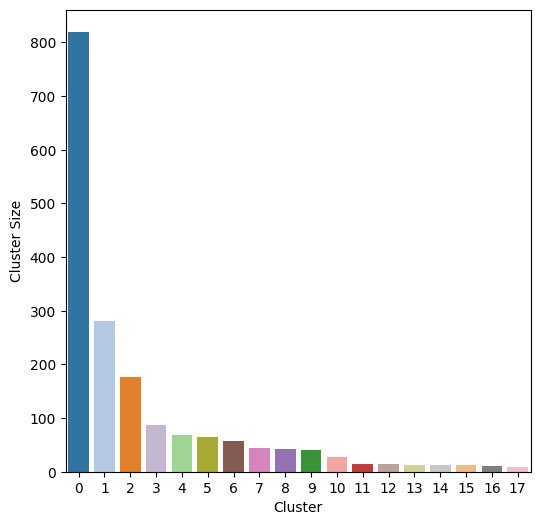

In [12]:
# Create a DataFrame from AnnData's obsd
df = subadata.obs[['leiden', 'binding2']]
# Calculate the ratio of "S+" in each cluster
ratio_s_plus = (df.groupby('leiden')['binding2'].apply(lambda x: (x == 'S+').sum() / x.count()).reset_index(name='Ratio of S+'))

# Calculate the size of each cluster
cluster_sizes = df['leiden'].value_counts().reset_index()
cluster_sizes.columns = ['leiden', 'Cluster Size']

# Merge the ratio and size data for plotting
plot_data = pd.merge(ratio_s_plus, cluster_sizes, on='leiden')
plot_data['Cluster Size'] = plot_data['Cluster Size'] 
# Plot the barplot for the ratio of S+
fig, ax = plt.subplots(figsize=(6, 6))
# Plot the barplot
sns.barplot(data=plot_data, x='leiden', y='Cluster Size', palette=cluster_colors, ax=ax)
#ax.set_xlim([-0.5,3])
ax.set_xlabel('Cluster')
ax.set_ylabel('Cluster Size')
plt.savefig("/mnt/d/unifiedBCR/figures/lineage/concat/lineage_filtered_leiden_size.pdf", bbox_inches='tight', dpi=100)

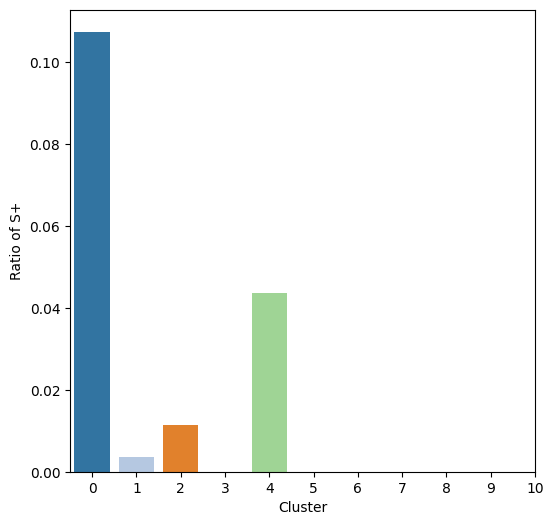

In [14]:
# Create a DataFrame from AnnData's obsd
df = subadata.obs[['leiden', 'binding2']]
# Calculate the ratio of "S+" in each cluster
ratio_s_plus = (df.groupby('leiden')['binding2'].apply(lambda x: (x == 'S+').sum() / x.count()).reset_index(name='Ratio of S+'))

# Calculate the size of each cluster
cluster_sizes = df['leiden'].value_counts().reset_index()
cluster_sizes.columns = ['leiden', 'Cluster Size']

# Merge the ratio and size data for plotting
plot_data = pd.merge(ratio_s_plus, cluster_sizes, on='leiden')

# Plot the barplot for the ratio of S+
fig, ax = plt.subplots(figsize=(6, 6))
# Plot the barplot
sns.barplot(data=ratio_s_plus, x='leiden', y='Ratio of S+', palette=cluster_colors, ax=ax)
ax.set_xlabel('Cluster')
ax.set_xlim([-0.5,10])
ax.set_ylabel('Ratio of S+')
plt.savefig("/mnt/d/unifiedBCR/figures/lineage/concat/lineage_filtered_leiden_ratio.pdf", bbox_inches='tight', dpi=100)